<h1>Predicción de venta de boletos para partidos de beisbol</h1>

### *Contexto del problema y objetivos*

La distribución y logistica de ventas es un problema abierto con una gran gama de opciones para optimización y mejora del rendimiento de procesos relacionados con la venta en general. En el contexto de la industria del entretenimiento y deportes, en particular de eventos relacionados con beisbol, la venta de boletos representa uno de los ingresos directos más relevantes cuando se habla del rendimiento monetario que tuvo cierto evento. Por lo que la distribución de entradas es fundamental para maximizar las ventas.

El problema central, dado el contexto anterior, radica en la distribución de la venta de entradas en un estadio perteneciente a un equipo de beisbol de méxico. Se tienen datos de las ventas en gasolinerías en los ultimos años de diferentes eventos suscitados en dicho estadio. Lo que se busca es un modelo que sea capaz de predecir cuantos boletos se van a vender para un evento en particular para tener un aproximado de cuantos boletos se deben apartar para venderse en gasolinerías, ya que si se dan de más o de menos, representa una perdida relevante para el negocio.


# Carga de datos 📂

El primer paso es obtener los datos, en este caso se usa la función **load_data**, la cual se encuentra definida al final de esta libreta, esta función recibe como argumentos la ruta donde se encuentra el archivo que se desea cargar y el nombre del archivo que se desea cargar. La función devuelve un DataFrame de pandas con los datos, este DataFrame se guarda con el nombre "data". Con esto podemos comenzar por realizar toda la preparación y pre-procesameinto antes de realizar cualquier entrenamiento.

In [ ]:
data = load_data('Path a los datos', 'Nombre - Archivo.csv')

Ahora se observan las primeras dos filas de los datos para poder conocer un poco más sobre el contenido de este DataFrame y asegurarnos que se cargaron correctamente columnas, filas y los encabezados están en orden. De no ser así se tendrían que realizar pasos extra para acomodar características adecuadamente.

In [ ]:
data.head(5)

Antes de poder usar algoritmos de Machine Learning, se deben poner los datos en un formato adecuado para que el algoritmo pueda aprender de ellos, además de esto, se deben eliminar valores NaN u otros valores que pudieran afectar al desempeño del modelo, esto se realiza en la sección de limpieza y preparación de los datos.

# Limpieza y preparación de datos 🧹

## Exploración 🔎

Usando la función **data_exploration** definida al final de esta libreta se puede obtener un análisis de todas las columnas en el DataFrame, esta función brinda información como el tipo de datos presentes en cada columna, el número de valores nulos y el número de valores únicos. La función data_exploration() devulve un DataFrame con los datos antes mencionados.
Dada la exploración de los tipos de datos leídos por pandas y el numero de valores unicos y nulos se podrían hacer diferentes pasos si hay algún error en el tipo de dato, si hay valores duplicados o si hay valores inexistentes.

In [ ]:
data_exploration(data)

Ya entrando en la interpretación de los datos, vemos que tenemos por cada fila un boleto vendido y por cada columna los datos de cada boleto, ID, area, evento, hey, precio, fecha, hora, asiento, precio, etc.

Lo que estamos buscando es predecir cuántos boletos se venderían por punto de venta, es por eso que hay que transformar nuestros datos a un nuevo dataset en el que sea posible aplicar métodos para la predicción. Para realizar ésto tenemos que preparar e idear las características relevantes para este nuevo dataset.

## Preparación 👍

Como primera propuesta, tomaremos los datos "individuales" de venta y construiremos un dataset en el que el target sea el numero de boletos vendidos y las características o features sean las que podamos obtener de los datos anteriores.

La idea de la predicción la podemos basar en la siguiente pregunta: Habrá un partido o evento "X" el dia de la semana "X" con fecha "X" y precio "X", ¿Cuantos boletos se venderán en la zona "X"?

Proponemos nuestro dataset con las siguientes características-columnas:

*   Evento
*   Dia/semana
*   mes
*   año
*   zona
*   Precio
*   **N de boletos vendidos**

Procedemos entonces a crear nuestro dataset. Comencemos por definir funciones que nos serán utiles para para preparación de nuestros datos.

In [ ]:
# Funciones utiles para la caracterización de nuestro dataset

#Esta función permite extraer de una fecha, que día de la semana fue.
def obtener_dia_semana(fecha_str):
    # Convertir la cadena de fecha al objeto datetime
    fecha = datetime.strptime(fecha_str, "%Y-%m-%d")

    # Obtener el día de la semana como número (0 para lunes, 1 para martes, etc.)
    dia_semana_num = fecha.weekday()

    # Mapear el número del día de la semana a su nombre correspondiente
    dias_semana = ["lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo"]
    dia_semana_nombre = dias_semana[dia_semana_num]

    return dia_semana_nombre

# De una fecha en particular obtenemos el mes.
def extraer_mes(fecha):
    fecha_objeto = datetime.strptime(fecha, '%Y-%m-%d')
    nombre_mes = fecha_objeto.strftime('%B')  # %B devuelve el nombre completo del mes
    return nombre_mes

# De una fecha en particular obtenemos el año.
def extraer_year(fecha):
    fecha_objeto = datetime.strptime(fecha, '%Y-%m-%d')
    año = fecha_objeto.year
    return año

# esta función usa label encoder para codificar valores categoricos
def encode_categorical(dataframe):
    le_dict = {}  # Diccionario para almacenar los LabelEncoders y mapeos

    df_codificado = dataframe.copy()

    for columna in df_codificado.columns:
        if df_codificado[columna].dtype == 'object':
            le = LabelEncoder()
            df_codificado[columna] = le.fit_transform(df_codificado[columna])
            le_dict[columna] = {'encoder': le, 'mapping': dict(zip(le.classes_, le.transform(le.classes_)))}

    return df_codificado, le_dict

# Esta función es capaz de hacer una analisis de ubral de varianzas
def varianceTreshold_analysis(data:pd.DataFrame) -> np.array:
  # Intuitivamente significa que eliminaremos los atributos que sean igual en proporción mayor o igual a 80%
  sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
  df_2 = pd.DataFrame(sel.fit_transform(data))
  return df_2

Dadas las nuevas caracteristicas buscadas tener para nuestro dataset a entrenar, nos encargamos primero de recorrer cada evento y luego, por cada zona, contar la cantidad de boletos vendidos, guardando el dia de la semana, mes, año y precio de dicho evento.

In [ ]:
# Construimos el nuevo dataset

# Definimos los nombres de los eventos presentes en el dataset, se repite el de Toros vs Generales, por lo que solo lo ponemos una vez
eventos_nombres = ['A vs B', 'C vs D', 'etc']
# Definimos ahora los nombres de las zonas disponibles para venta
zonas_nombres = []

# Definimos el dataset con las columnas de nuestras nuevas caracteristicas
df_nuevo = pd.DataFrame(columns=['Evento', 'dia', 'mes', 'anio', 'Zona', 'Precio', 'Venta'])

# Escribimos cada elemento del dataframe, vamos seccionando partes hasta dar con el conteo de boletos por evento y zona.
#Recorremos cada evento
for evento in eventos_nombres:
  # Seccionamos los valores para el evento en turno del for
  data_item = data[data['eve_titulo'] == evento]

  for zona in zonas_nombres:
    # recorremos cada zona para tener por evento una fila diferente por zona
    #Definimos la fila guardando el evento, dia, mes, año, precio (tomando el primer elemento de referencia de los agrupados) y las ventas
    dataset_test = {'Evento': [evento],
                    'dia': [obtener_dia_semana(data_item[data_item['area_desc'] == zona].iloc[0].loc['fe_fecha'])],
                    'mes': [extraer_mes(data_item[data_item['area_desc'] == zona].iloc[0].loc['fe_fecha'])],
                    'anio': [extraer_year(data_item[data_item['area_desc'] == zona].iloc[0].loc['fe_fecha'])],
                    'Zona': [data_item[data_item['area_desc'] == zona].iloc[0].loc['tic_area_id']],
                    'Precio': [data_item[data_item['area_desc'] == zona].iloc[0].loc['tic_precio_boleto']],
                    'Venta': [data_item.groupby("area_desc")["tic_vta_id"].count().sort_values(ascending=False).loc[zona]]}
                    #Para las ventas usamos groupby para agrupar los boletos por zona, contamos cuantos son con count, ordenamos y guardamos en nuestra fila.

    # Agregamos las nuevas filas
    frames = [df_nuevo, pd.DataFrame(dataset_test)]
    #Vamos concatenando cada fila
    df_nuevo = pd.concat(frames, ignore_index=True)

#Observamos las primeras 6 filas del nuevo dataset
df_nuevo.head(6)

Finalmente, para quedarnos con los valores, elimianmos espacios en blanco que pudiesen ahber dentro de los string de las variables categoricas.

In [ ]:
#Eliminamos espacios en blanco
df_nuevo['Evento'] = df_nuevo['Evento'].str.strip()
df_nuevo['Evento'] = df_nuevo['Evento'].str.replace(r'\s+', ' ', regex=True)

Ya tenemos nuestro datset adecuado, lo que nos falta es prepararlo para el entrenamiento y validación.

Hacemos la codificación de las variables categoricas del dataset. De momento tenemos un mismo año para todos nuestros datos, así que quitaremos esta columna de momento. De ahí nos dedicaremos entonces a separar las columnas numericas de las categoricas para transfomar estas ultimas en valores numericos usando una funcion "encode categorical" definida anteriormente.

In [ ]:
# Separar las variables categóricas y numéricas

#Quitamos el año
df_nuevo = df_nuevo.drop('anio', axis=1)
#Hacemos numericas las columnas
df_nuevo['Zona'] = df_nuevo['Zona'].astype(float)
df_nuevo['Precio'] = df_nuevo['Precio'].astype(float)
df_nuevo['Venta'] = df_nuevo['Venta'].astype(float)

categorias = df_nuevo[['Evento', 'dia', 'mes']]
numericas = df_nuevo[['Zona', 'Precio', 'Venta']]

# Realizar codificación de las variables categóricas
categorias_codificadas, le_dict = encode_categorical(categorias)

# Crear un nuevo DataFrame con las variables codificadas y las numéricas originales
# Combinar las variables codificadas con las numéricas originales
dataset_ventas = pd.concat([categorias_codificadas, numericas], axis=1)

dataset_ventas.head(80)

,Evento,dia,mes,Zona,Precio,Venta
0,10,4,0,3.0,250.0,8136.0
1,10,4,0,24.0,450.0,5832.0
2,10,4,0,1.0,600.0,5576.0
3,10,4,0,25.0,350.0,5040.0
4,18,1,4,3.0,50.0,282.0
...,...,...,...,...,...,...
75,1,4,5,25.0,180.0,106.0
76,11,4,5,3.0,50.0,154.0
77,11,4,5,24.0,250.0,128.0
78,11,4,5,1.0,320.0,70.0


Hacemos un histograma por variable para tener una idea de la distribución general de las frecuencias por cada variable analizada, esto es importante en cuestiones como arboles de desiciónpor ejemplo, ya que pueden ser factores de importancia en el creación de nodos de decisión.

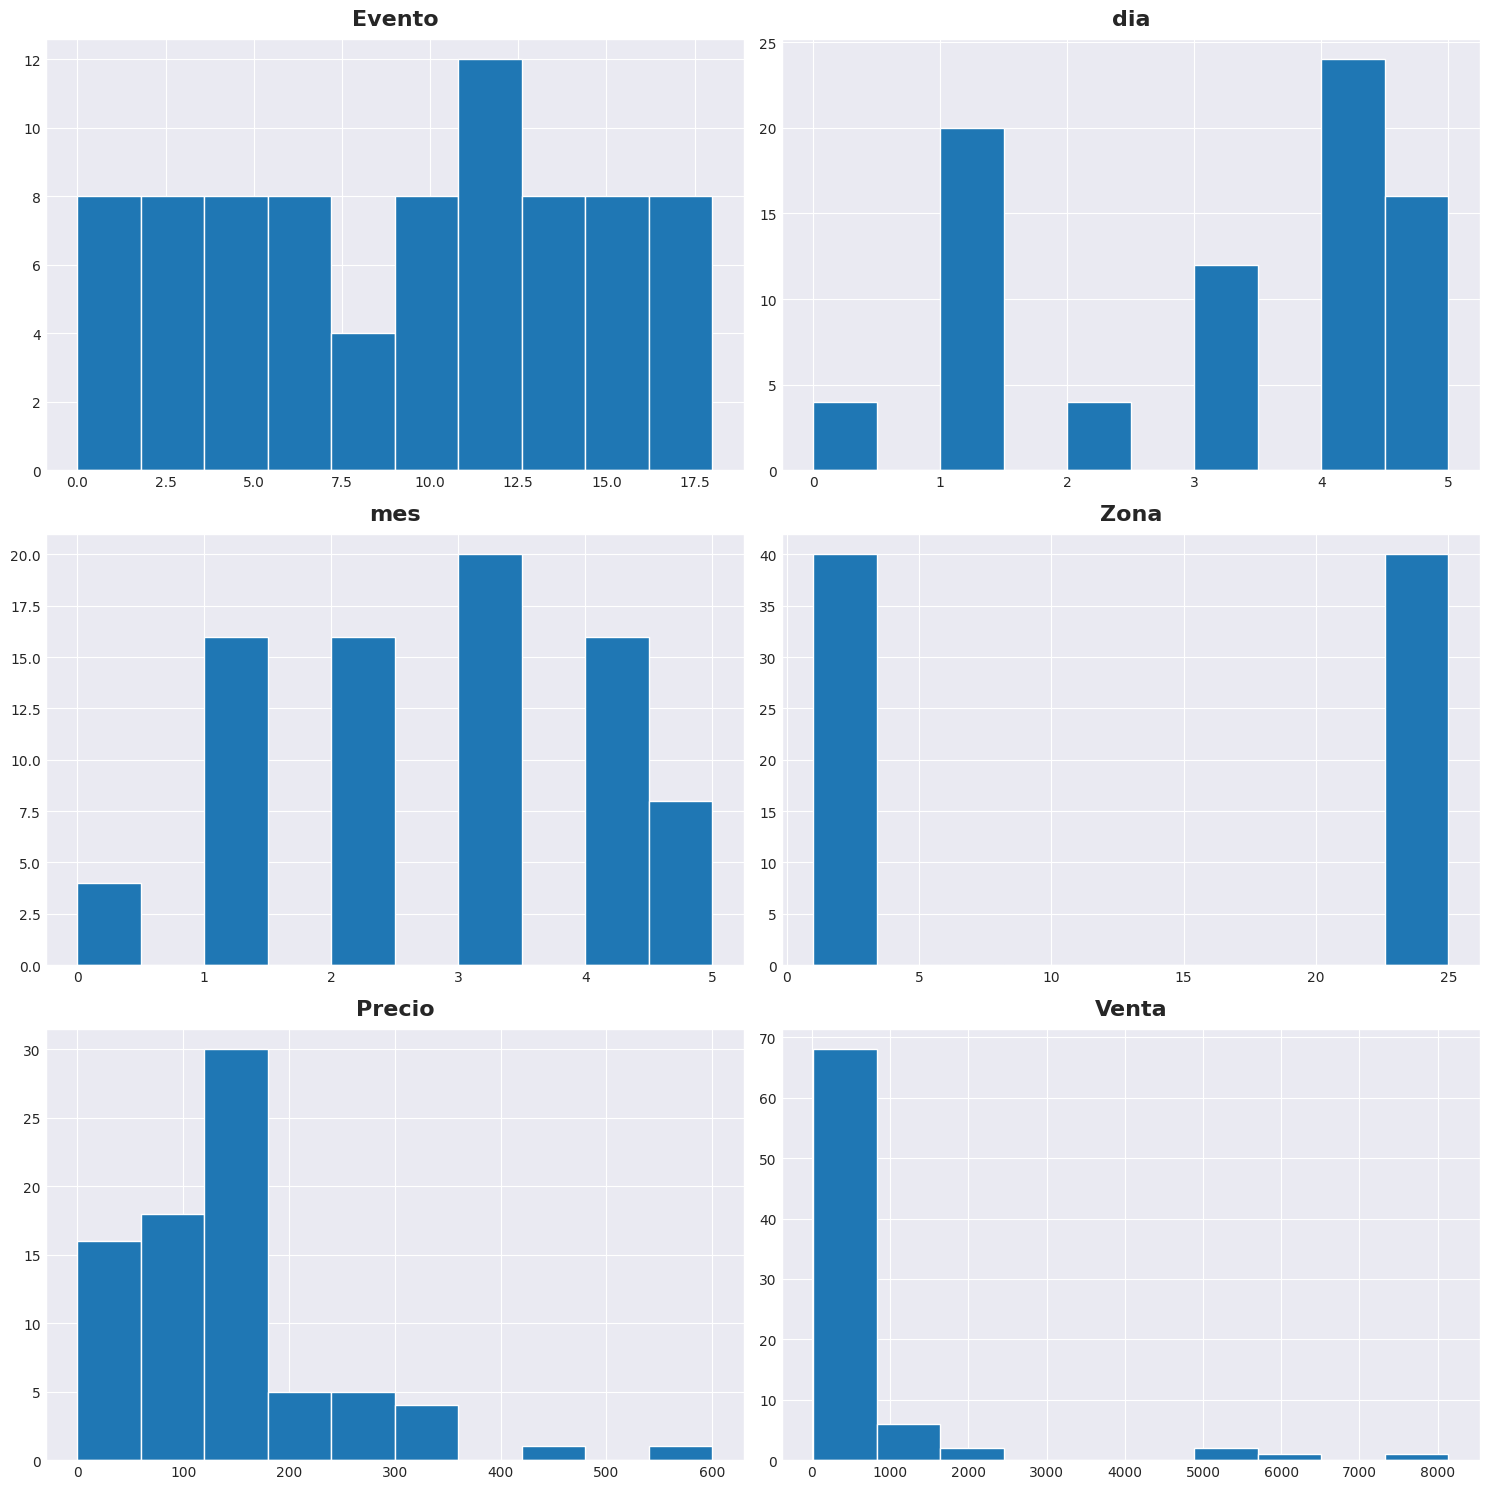

In [ ]:
sns.set_style("darkgrid")
dataset_ventas.hist(figsize=(15,15))
plt.show()

Con esto, siguiendo el orden de cada grafico, vemos que en general a excepción de dos intervalos tenemos una frecuencia igual de la repetición de filas con los mismos eventos por lo que en promedio esta balanceado el dataset en eventos. En cuestión a la frecuencia de los días, los que más se repitieron fueron los jueves y sabado, lo cual es importante a considerar ya que podría ser un filtro importante en cuestión a cuantos eventos fueron estos días. Respecto al mes se ve una cuestión mas balanceada corresponde a la temporada que siguiendo el grafico corresponden a Agosto, Julio, Junio y mayo. Vemos una distribución en las zonas practicamente igual. En cuanto a precios la gran mayoria en frecuencia está de 0 a 150 y finalmente, hay mayor repetición en valores de ventas de 0 1000.

Ahora bien, para entrenar un modelo de Machine Learning para predicción (aprendizaje supervisado) es necesario pasarle a este por separado las features o características de las que debe aprender y la salida esperada o target para cada feature, para que el modelo pueda ajustar los parámetros si es que las predicciones no son cercanas a los targets.

Por esto, se procede a separar del DataFrame las columnas que se usarán como features y se almacenan en la variable "X", por otra parte, se usarán como targets la cuenta de boletos vendidos, esta se almacena en la variable "y"

In [ ]:
# Separar features y targets
y = dataset_ventas['Venta']
X = dataset_ventas.drop('Venta', axis=1)

## Análisis de los datos bivariantes (Bivariate Analysis)



Como primer análisis a nuestras nuevas features hacemos un Bivariate Analysis para averiguar la relación que existe entre columnas. Calculamos la matriz de correlación entre variables.

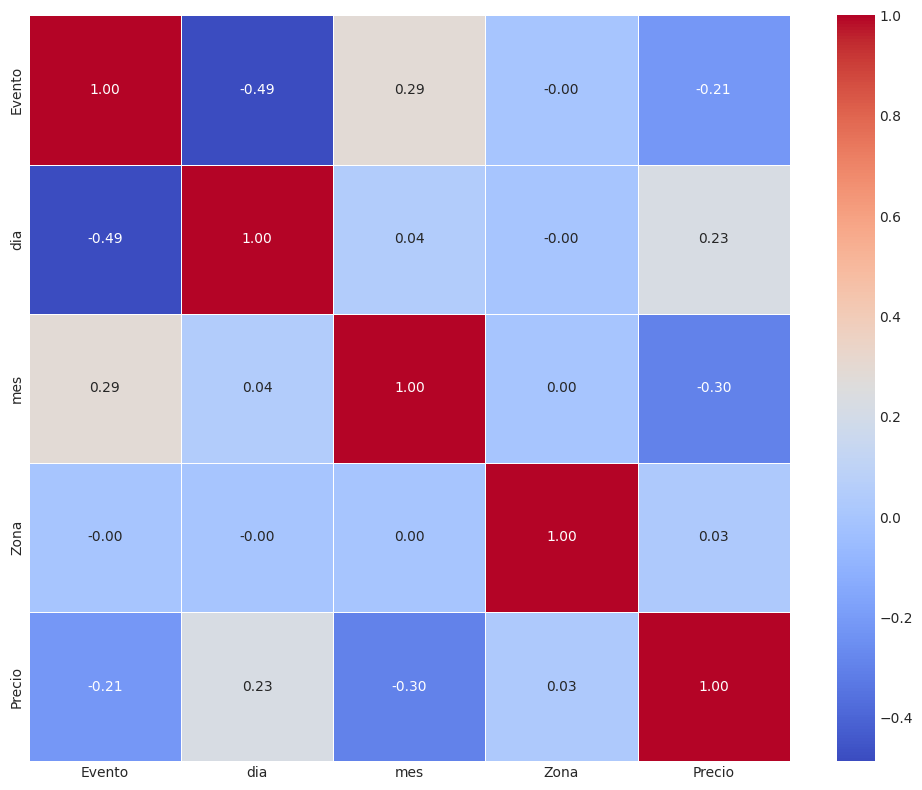

In [ ]:
correlation_matrix = X.corr()

# Visializamos la matriz de correlación en un heat map
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# Ajustamos los límites de los ejes para evitar recortar los bordes del heat map
plt.ylim(len(correlation_matrix), 0)
plt.xlim(0, len(correlation_matrix))
# Mostrar el heat map
plt.show()

# Identificamos las variables altamente correlacionadas
correlated_variables = correlation_matrix[correlation_matrix > 0.8]

En general, no hay correlación alta entre cada variable, el mayor registrado es de 0.29 y corresponde a una correlación entre evento y mes, lo cual tiene sentido por como se estructuran los juegos en las temporadas. En general, este primer filtro nos dice que no hay ninguna correlación grande entre variables que nos permita despreciar alguna.

Como segunda prueba hacemos este mismo analisis pero con un umbral de varianzas para tener cuantitativamente confirmada la observación anterior, además quitamos de nuestro analisis la variable a predecir para ya hacer la preparación y segmentación de datos de entrenamiento y prueba.

In [ ]:
# Hacemos un análisis de umbral de varianza
data_VT = dataset_ventas.drop('Venta', axis=1)
y_VT = dataset_ventas['Venta']

X_VT = varianceTreshold_analysis(data_VT)
X_VT.head()

,0,1,2,3,4
0,10.0,4.0,0.0,3.0,250.0
1,10.0,4.0,0.0,24.0,450.0
2,10.0,4.0,0.0,1.0,600.0
3,10.0,4.0,0.0,25.0,350.0
4,18.0,1.0,4.0,3.0,50.0


Dado lo calculado anteriormente, no hay señales de correlación alta entre las variables, esto lo podemos decir por que se conservó el numero de columnas en este umbral, así que haremos el entrenamiento con todas las características propuestas.

# Entrenamiento   ⛏

Ahora se divide el dataset en dos subsets, uno para entrenar el modelo y el otro para evaluar al modelo, estos subsets se conocen como set de entrenamiento y set de prueba, respectivamente.

Lo anterior es importante ya que el modelo debe evaluarse con datos que no haya visto antes, es decir, datos que no son parte del conjunto de datos con el que se entrenó, esto para evitar sesgar la evaluación y que pueda parecer que el modelo tiene un buen desempeño cuando en realidad puede estar "memorizando" los datos.

Esto se hace usando la función "train_test_split" de sklearn a la cual se le pasan las features y targets que se quieren dividir en entrenamiento y prueba, el tamaño del set de prueba que en este caso será el 10% del total de datos disponibles, y si se quieren mezclar o no los datos antes de dividir el dataset, en este caso, al estar trabajando con datos temporales, no se mezclan los datos ya que es importante el orden en el que estos están. La función devuelve las features para entrenamiento y para prueba, y los targets para entrenamiento y para prueba, lo anterior se almacena en las variables "X_train", "X_test", "y_train" y "y_test", respectivamente.

In [ ]:
# Dividir el dataset en entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

Ahora que ya se ha hecho el preprocesamiento de los datos, y se han obtenido las características que se usarán se puede pasar a entrenar el modelo para predicción.

# Modelos de entrenamiento 📈

Para realizar las predicciones de ventas se entrenarán diferentes modelos y se evaluarán ambos para determinar cuál de estos tres modelos es mejor para realizar las predicciones. Los tres modelos que se entrenarán son:

- Árbol de decisión
- Regresor de Gradient Boosting
- Redes Neuronales LSTM
- Adaboost
- Random Forest
- XGBoost
- LightGBM
- SVR


##Construcción del modelo 🔨

A continuación, se inicializa cada uno de los modelos, se entrena el modelo con los datos de entrenamiento previamente obtenidos y se realizan predicciones sobre el set de prueba con el modelo entrenado.

Preparamos y construimos cada modelo mencionado anteriormente tomando la misma estructura: Definición, entrenamiento y predicción.

In [ ]:
# Importar el modelo de sklearn
from sklearn.tree import DecisionTreeRegressor

# Inicializar el modelo
dt_reg = DecisionTreeRegressor(random_state=42)

# Entrenar el modelo
dt_reg.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
dt_pred = dt_reg.predict(X_test)

# Mostrar las predicciones del modelo
dt_pred

array([ 156.,  416.,  114.,  366.,   42., 1698.,  114.,  168.])

Ahora se construye el modelo de Gradient Boosting Regressor. Las predicciones de este modelo se guardan en la variable "gbr_pred".

In [ ]:
# Importar el modelo de sklearn
from sklearn.ensemble import GradientBoostingRegressor

# Inicializar el modelo
gbr = GradientBoostingRegressor(random_state=42)

# Entrenar el modelo
gbr.fit(X_train, y=y_train.ravel())

# Realizar predicciones sobre el set de prueba
gbr_pred = gbr.predict(X_test)

# Mostrar las predicciones
gbr_pred

array([ 167.92259452, 2552.76533515,  132.20114184,  349.17470563,
        -45.98021294, 1359.53411437,  586.23504786,  316.70885045])

In [ ]:
# Reshape de la data para pasarla a la LSTM
X_train_lstm = X_train.to_numpy().reshape((-1, X_train.shape[1], 1))
X_test_lstm = X_test.to_numpy().reshape((-1, X_test.shape[1], 1))

In [ ]:
# Construir modelo de LSTM
lstm = Sequential()
lstm.add(LSTM(50, activation="relu", input_shape=(X_train_lstm.shape[1:])))
lstm.add(Dense(1))

# Configurar el modelo para el entrenamiento
"""
Optimizador: Adam
learning_rate: 0.0001
loss: mse
metrica: mse
"""
lstm.compile(optimizer="adam", loss="mse", metrics=["mse"])

In [ ]:
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenar el modelo por 100 epocas
historia_lstm = lstm.fit(X_train_lstm, y_train, batch_size=32, epochs=100, verbose=1)

Epoch 1/100
3/3 [==============================] - 1s 5ms/step - loss: 1529358.5000 - mse: 1529358.5000
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 1526686.2500 - mse: 1526686.2500
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 1524660.6250 - mse: 1524660.6250
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 1522389.3750 - mse: 1522389.3750
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 1521134.3750 - mse: 1521134.3750
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 1519645.5000 - mse: 1519645.5000
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 1518559.2500 - mse: 1518559.2500
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 1517261.0000 - mse: 1517261.0000
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 1516300.5000 - mse: 1516300.5000
Epoch 10/100
3/3 [==============================] - 0s 4ms/step 

In [ ]:
# Realizar predicciones sobre el set de prueba
lstm_pred = lstm.predict(X_test)
lstm_pred = lstm_pred.reshape(len(lstm_pred))

# Mostrar las predicciones
lstm_pred

1/1 [==============================] - 0s 177ms/step


array([188.48697, 401.52127, 153.68068, 234.0001 , 194.47932, 202.97562,
       175.64444, 763.5171 ], dtype=float32)

In [ ]:
#Adaboost regresor

# Importar el modelo de sklearn
from sklearn.ensemble import AdaBoostRegressor

# Inicializar el modelo
model_Adaboost =  AdaBoostRegressor()

# Entrenar el modelo
model_Adaboost.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
ADA_pred = model_Adaboost.predict(X_test)

# Mostrar las predicciones
ADA_pred


array([ 439.33333333,  528.76923077,  377.11111111,  503.79310345,
        285.15789474, 1510.96774194,  427.38461538,  377.11111111])

In [ ]:
#Random Forest

# Importar el modelo de sklearn
from sklearn.ensemble import RandomForestRegressor

# Inicializar el modelo
model_RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Entrenar el modelo
model_RF.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
RF_pred = model_RF.predict(X_test)

# Mostrar las predicciones
RF_pred

array([ 228.4       , 2496.45      ,  146.32571429,  400.32      ,
         41.911     , 1374.16      ,  242.96238095,  445.5       ])

In [ ]:
#XGBOOST

# Importar el modelo de sklearn
import xgboost as xgb

# Inicializar el modelo
model_xgboost = xgb.XGBRegressor(objective='reg:squarederror')

# Entrenar el modelo
model_xgboost.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
XGB_pred = model_xgboost.predict(X_test)

# Mostrar las predicciones
XGB_pred

array([ 175.22455 , 5120.069   ,  142.81197 ,  389.38223 ,   51.680054,
       1115.7129  ,  296.97208 ,  198.4709  ], dtype=float32)

In [ ]:
#LightGBM

# Importar el modelo de sklearn
import lightgbm as lgb

# Inicializar el modelo
model_lgb = lgb.LGBMRegressor()

# Entrenar el modelo
model_lgb.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
LGB_pred = model_lgb.predict(X_test)

# Mostrar las predicciones
LGB_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 5
[LightGBM] [Info] Start training from score 579.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

array([ 570.39054564, 2594.06884948,  965.09749996,  540.24544519,
        269.23222937,  540.24544519,  866.53108985,  540.13866054])

In [ ]:
#Maquina de vector soporte

from sklearn.svm import SVR

# Inicializar el modelo
svr = SVR(kernel='rbf')

# Entrenar el modelo
svr.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
svr_pred = svr.predict(X_test)

## Comparación de los modelo 📊

Una vez se tienen los dos modelos entrenados y se han obtenido las predicciones de ambos, es necesario comparar estos dos modelos para determinar cuál obtiene los mejores resultados y usar este modelo para las predicciones de las ventas.

Para poder comparar los modelos se necesita elegir una métrica de desempeño con la cual se evaluará cada uno de los modelo. En este caso se usará como métrica de desempeño el error absoluto medio porcentual (MAPE), el cual se define por la siguiente expresión:

\begin{align}
        MAPE = \frac{1}{n} \sum_{i=1} ^{n} \frac{\mid y_i - \hat{y_i} \mid}{\mid y_i \mid}
    \end{align}

Donde:
- $n$ es el número de datos en el set
- $y_i$ es el valor real de la observación (targets)
- $\hat{y_i}$ es el valor predicho de la observación

Un MAPE cercano a cero indica que el modelo realiza buenas predicciones, que se acercan mucho a los targets.

En la siguiente función se define la funcion "mape", la cual recibe como entrada los targets y las predicciones del modelo. Como su nombre lo indica, la función devuelve el MAPE.

In [ ]:
def mape(y_true, y_pred):
  return round(np.mean(np.abs((y_true - y_pred) / y_true)), 2)
  #return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

En la siguiente celda se calcula el MAPE de la predicción baseline, el MAPE de las predicciones del árbol de decisión y el MAPE de las predicciones del Gradient Boosting Regressor.

Además de esto, se grafican cada uno de estos MAPES para observar cuales son las predicciones más cercanas a los targets.

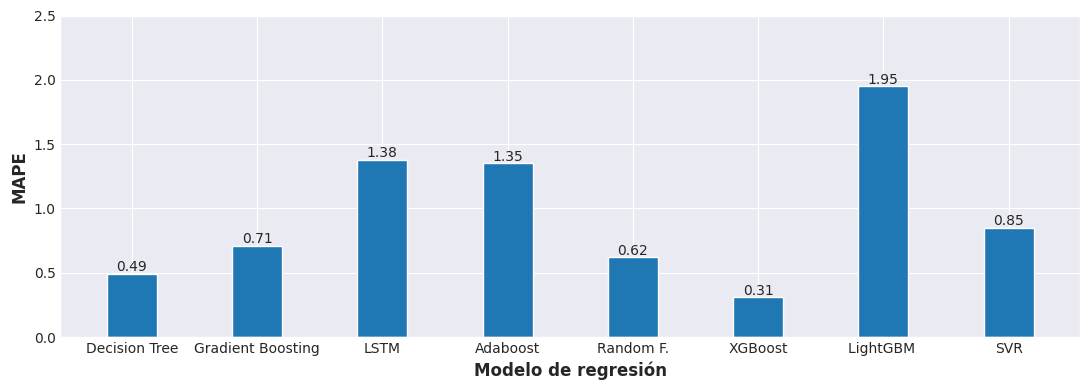

In [ ]:
# Calcular los mape del baseline, el arbol de decision y el Gradient Boosting

dt_mape = mape(y_test, dt_pred)
gbr_mape = mape(y_test, gbr_pred)
lstm_mape = mape(y_test, lstm_pred)
ada_mape = mape(y_test, ADA_pred)
rf_mape = mape(y_test, RF_pred)
xgb_mape = mape(y_test, XGB_pred)
gbm_mape = mape(y_test, LGB_pred)
svr_mape = mape(y_test, svr_pred)

# Graficar los mape
fig, ax = plt.subplots()
x = ['Decision Tree', 'Gradient Boosting', "LSTM", 'Adaboost', 'Random F.', 'XGBoost', 'LightGBM ', 'SVR']
y = [dt_mape, gbr_mape, lstm_mape, ada_mape, rf_mape, xgb_mape, gbm_mape, svr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Modelo de regresión')
ax.set_ylabel('MAPE')
ax.set_ylim(0, 2.5)

# Agregar el MAPE a la grafica
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')

plt.tight_layout()

De la gráfica anterior se observa que el modelo que obtuvo el menor MAPE, y por lo tanto tiene el mejor desempeño es el modelo de Gradient Boosting, con un MAPE de 0.31, este MAPE es mejor que el de las predicciones de la LSTM. Por otra parte, el peor modelo fue el del LightGBM, con un MAPE de 1.91.

**¿Como interpretamos esto valores?**

El valor MAPE, como se mencionó anteriormente es una medida respecto al error de la predicción con respecto al valor real. Al trabajar con regresión, no se tienes clases fijas que clasificar, por lo que tenemos valores en el continuo que buscamos predecir, de ahí el que tengamos valores decimales o flotantes. De fomra practica, tenemos un porcentaje de error respecto a los valores de prueba utilizados. Aquí hay muchos factores a mencionar, el dataset que estamos usando en relativamente pequeño, no en cuanto a los datos de los boletos, sinó a los datos de entrada del modelo, ya que al crear nuestro dataset, nos quedamos solo con 80 filas. cada fila representa los boletos vendidos en un cierto evento en determinada zona, por lo que por evento son 4 filas, no hay una relación temporal en cuanto a debido el tiempo, se haya obtenido cierta venta, sino que se consideran factores directos como, el precio, dia, mes, evento y zona como lo que puede variar cuantitativamente para que se venda cierto numero de boletos. Y esto nos da una buena flexibilidad, ya que dandole al modelos los datos del evento que quieras predecir, te arrojará el numero de boletos estimado, cosa que con series de tiempo no se podría hacer.

In [ ]:
print(y_test)

30     240.0
0     8136.0
22     216.0
31     276.0
18      48.0
28    1020.0
10     474.0
70     128.0
Name: Venta, dtype: float64


In [ ]:
for valor1, valor2 in zip(y_test.tolist(), XGB_pred):
  print(f'Valor real: {valor1}, Predicho: {valor2}')

Valor real: 240.0, Predicho: 175.22454833984375
Valor real: 8136.0, Predicho: 5120.06884765625
Valor real: 216.0, Predicho: 142.8119659423828
Valor real: 276.0, Predicho: 389.3822326660156
Valor real: 48.0, Predicho: 51.6800537109375
Valor real: 1020.0, Predicho: 1115.712890625
Valor real: 474.0, Predicho: 296.9720764160156
Valor real: 128.0, Predicho: 198.4709014892578


En cuanto a los resultados, en la celda anterior podemos apreciar directamente los valores reales con la predicción del modelo, en promedio tenemos un error del 31% sin embargo, para fines practicos, el fallar por un rango de unidades o incluso decenas no es una cuestion relevante en las ventas por lotes ya que no deja de ser un sistema complejo en el que hay infinidad de valores que podrían afectar en que se vendan o no la cantidad de boletos predichos, y vemos en los resultados que no hay muchos casos en los que la predicción diste del orden de millares a excepción del segundo, y esto es debidoa que si revisamos los datos, corresponde a un valor atipico corresponde a las otras zonas, del cual no se tuvo información previa.

En conclusión, se tuvieron buenos resultados usando un modelo de base en xgboost, el cual nos dió el menor error posible en contraste a otros modelos utilizados.

# ⚠️ Importante
## Ejecutar esta celda antes de ejecutar *TODAS* las anteriores❗

Importamos y descargamos librerias y hacemos los ajustes necesarios en formato para el codigo.

In [ ]:
# Dependencias
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics.cluster import silhouette_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
import locale

#Librerias externas que hay que instalar a colab
!pip install xgboost
!pip install lightgbm

#Settings para los graficos realizados
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

<ipython-input-1-036225c7d876>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Montamos el Drive, ya que de aquí traeremos los datos

In [ ]:
# Montar drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Definimos funciones para el codigo.

In [ ]:
def load_data(path:str, file_name:str)->pd.DataFrame:
  # Montar el drive
  path_ = '/content/gdrive/MyDrive/' + path

  type_file = file_name.split('.')[1]

  if type_file == 'xlsx':
    print("loaded file: " + path_ + file_name)
    return pd.read_excel(path_ + file_name)
  elif type_file == 'csv':
    print("loaded file: " + path_ + file_name)
    return pd.read_csv(path_ + file_name)
  else:
    raise AttributeError("type file not valid")

def data_exploration(data:pd.DataFrame)-> pd.DataFrame:
  exploration = pd.DataFrame(columns = data.columns,
                           index=['type','null_counts','uniques'])
  # shape of dataframe
  shape = data.shape
  #data['shape rows'] = shape[0]
  # num of nulls per column
  null_counts = data.isnull().sum()
  exploration.loc['null_counts'] = null_counts
  # categorical or numeric data columns
  cat_cols = [col for col in data.columns if col not in data.describe().columns]
  num_cols = data._get_numeric_data().columns
  exploration.loc['type', cat_cols] = 'categorical'
  exploration.loc['type', num_cols] = 'numeric'
  # unique values
  exploration.loc['uniques', data.nunique().index] = data.nunique().values

  return exploration